# Reading the MNIST data set

* The images from the data set have the size 28 x 28. They are saved in the csv data files mnist_train.csv and mnist_test.csv.
* Every line of these files consists of an image, i.e. 785 numbers between 0 and 255.
* The first number of each line is the label, i.e. the digit which is depicted in the image. The following 784 numbers are the pixels of the 28 x 28 image.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

train_data = np.loadtxt("mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt("mnist_test.csv", 
                       delimiter=",") 
test_data[:10]

array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [3]:
test_data.shape

(10000, 785)

The images of the MNIST dataset are greyscale and the pixels range between 0 and 255 including both bounding values. We will map these values into an interval from [0.01, 1] by multiplying each pixel by 0.99 / 255 and adding 0.01 to the result. This way, we avoid 0 values as inputs, which are capable of preventing weight updates

In [4]:
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

We need the labels in our calculations in a one-hot representation. We have 10 digits from 0 to 9, i.e. lr = np.arange(10).

Turning a label into one-hot representation can be achieved with the command: (lr==label).astype(np.int)

We demonstrate this in the following:

In [5]:
lr = np.arange(10)

for label in range(10):
    one_hot = (lr==label).astype(np.int)
    print("label: ", label, " in one-hot representation: ", one_hot)

label:  0  in one-hot representation:  [1 0 0 0 0 0 0 0 0 0]
label:  1  in one-hot representation:  [0 1 0 0 0 0 0 0 0 0]
label:  2  in one-hot representation:  [0 0 1 0 0 0 0 0 0 0]
label:  3  in one-hot representation:  [0 0 0 1 0 0 0 0 0 0]
label:  4  in one-hot representation:  [0 0 0 0 1 0 0 0 0 0]
label:  5  in one-hot representation:  [0 0 0 0 0 1 0 0 0 0]
label:  6  in one-hot representation:  [0 0 0 0 0 0 1 0 0 0]
label:  7  in one-hot representation:  [0 0 0 0 0 0 0 1 0 0]
label:  8  in one-hot representation:  [0 0 0 0 0 0 0 0 1 0]
label:  9  in one-hot representation:  [0 0 0 0 0 0 0 0 0 1]


We are ready now to turn our labelled images into one-hot representations. Instead of zeroes and one, we create 0.01 and 0.99, which will be better for our calculations:

In [6]:
lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float)
test_labels_one_hot = (lr==test_labels).astype(np.float)

# we don't want zeroes and ones in the labels neither:
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99

Before we start using the MNIST data sets with our neural network, we will have a look at some images:

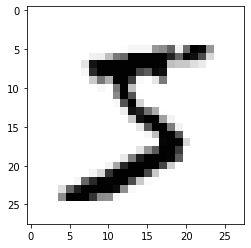

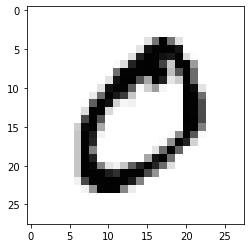

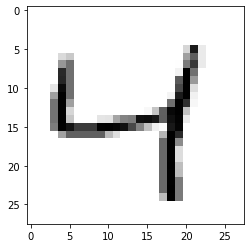

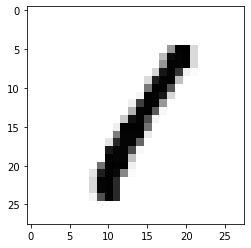

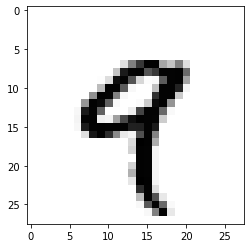

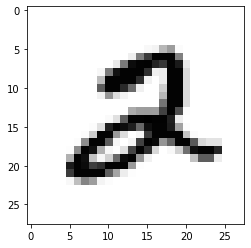

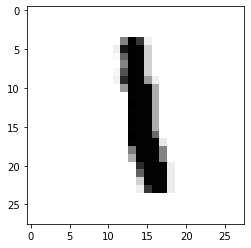

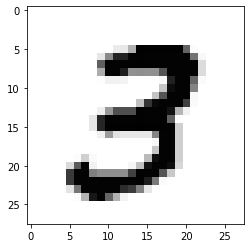

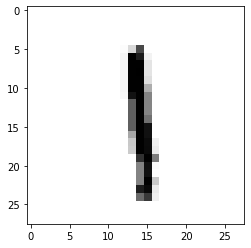

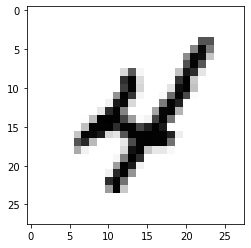

In [7]:
for i in range(10):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

We will save the data in binary format with the dump function from the pickle module:

# Dumping the Data for Faster Reload

In [8]:
import pickle

with open("pickled_mnist.pkl", "bw") as fh:
    data = (train_imgs, 
            test_imgs, 
            train_labels,
            test_labels,
            train_labels_one_hot,
            test_labels_one_hot)
    pickle.dump(data, fh)


We are able now to read in the data by using pickle.load. This is a lot faster than using loadtxt on the csv files:

In [9]:
with open("pickled_mnist.pkl", "br") as fh:
    data = pickle.load(fh)

train_imgs = data[0]
test_imgs = data[1]
train_labels = data[2]
test_labels = data[3]
train_labels_one_hot = data[4]
test_labels_one_hot = data[5]

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

# Classifying the Data

We will use the following neuronal network class for our first classification:

In [10]:
@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)
activation_function = sigmoid

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))
        
    
    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """
        
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)
        

        
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
            
    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    
    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
        
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [11]:
ANN = NeuralNetwork(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)
    
    
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])

In [12]:
for i in range(20):
    res = ANN.run(test_imgs[i])
    print(test_labels[i], np.argmax(res), np.max(res))

[7.] 7 0.9968345286754011
[2.] 2 0.9772953106377139
[1.] 1 0.9823430350404382
[0.] 0 0.9695479231122937
[4.] 4 0.9672038042529486
[1.] 1 0.9813139052665224
[4.] 4 0.9614243698696023
[9.] 9 0.98885106428077
[5.] 6 0.35996002789759485
[9.] 9 0.9329720672377291
[0.] 0 0.9676551277253882
[6.] 6 0.8436094528186614
[9.] 9 0.9885064394081708
[0.] 0 0.9862655745830785
[1.] 1 0.9905652221427104
[5.] 5 0.7733405050320421
[9.] 9 0.9894219000744935
[7.] 7 0.9930605044631804
[3.] 3 0.594059103395743
[4.] 4 0.9865275950497047


In [13]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects / ( corrects + wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy: test", corrects / ( corrects + wrongs))

cm = ANN.confusion_matrix(train_imgs, train_labels)
print(cm)

for i in range(10):
    print("digit: ", i, "precision: ", ANN.precision(i, cm), "recall: ", ANN.recall(i, cm))

accuracy train:  0.9454
accuracy: test 0.9448
[[5797    1   61   13   16   42   40   17   23   32]
 [   1 6625   44   30   12   38   18   67  106   10]
 [   2   22 5517   49   10   12    0   46   16    6]
 [   9   36  105 5805    0  177    1   24  139   85]
 [  10   12   59   11 5515   34    8   47   53   89]
 [   5    4    5   44    0 4866   25    2   10    3]
 [  35    6   52   13   47   86 5795    9   43    4]
 [   2    4   33   38    2    4    0 5774    1   22]
 [  41   12   67   59   14   75   30   17 5350   18]
 [  21   20   15   69  226   87    1  262  110 5680]]
digit:  0 precision:  0.9787269964544995 recall:  0.9594505130751407
digit:  1 precision:  0.9826460990803916 recall:  0.9531002733419652
digit:  2 precision:  0.9259818731117825 recall:  0.9713028169014084
digit:  3 precision:  0.9468275974555538 recall:  0.9097320169252469
digit:  4 precision:  0.9440260184868196 recall:  0.9446728331620418
digit:  5 precision:  0.8976203652462645 recall:  0.9802578565672845
digit:  6

# Multiple Runs

We can repeat the training multiple times. Each run is called an "epoch".

In [14]:
epochs = 3

NN = NeuralNetwork(no_of_in_nodes = image_pixels, 
                   no_of_out_nodes = 10, 
                   no_of_hidden_nodes = 100,
                   learning_rate = 0.1)


for epoch in range(epochs):  
    print("epoch: ", epoch)
    for i in range(len(train_imgs)):
        NN.train(train_imgs[i], 
                 train_labels_one_hot[i])
  
    corrects, wrongs = NN.evaluate(train_imgs, train_labels)
    print("accuracy train: ", corrects / ( corrects + wrongs))
    corrects, wrongs = NN.evaluate(test_imgs, test_labels)
    print("accuracy: test", corrects / ( corrects + wrongs))

epoch:  0
accuracy train:  0.9486
accuracy: test 0.9482
epoch:  1
accuracy train:  0.9634333333333334
accuracy: test 0.9575
epoch:  2
accuracy train:  0.9702833333333334
accuracy: test 0.9603
